In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import plotly.graph_objects as go
import plotly.express as px

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pickle
import os
import gc

os.chdir("./제6회 L.POINT Big Data Competition/")

def resumetable(df):
    print(f"DataSet Shape : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns={'dtypes'})
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name","dtypes"]]
    summary['Missing'] = df.isnull().sum().values
    summary['Unique'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, "Entropy"] = round(stats.entropy(df[name].value_counts(normalize = True), base=2),2)
        
    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

##### 공휴일 정보

In [1]:
"""
import requests
from bs4 import BeautifulSoup

years = [2019]
months  = ["07","08","09"]

holiday_list = []
for year in years:
    for month in months:
        api_key = 'jTMT5wK9lV8UjusD4JWaRX68i%2BBYksj3shiHJcgsIjkXPiNvoz%2FDanOlGtDPbn9neN1We3lmn7IqDvQHKbwbfQ%3D%3D'
        url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear={}&solMonth={}&ServiceKey={}'.format(year,month,api_key)
        get_data = requests.get(url)
        soup = BeautifulSoup(get_data.content, 'html.parser')
        table = soup.find_all('locdate')
        holiday_list = holiday_list + [day.text for day in table]

with open("holiday_
list.pickle", "wb") as f:
    pickle.dump(holiday_list, f, protocol=pickle.HIGHEST_PROTOCOL)
"""

'\nimport requests\nfrom bs4 import BeautifulSoup\n\nyears = [2019]\nmonths  = ["07","08","09"]\n\nholiday_list = []\nfor year in years:\n    for month in months:\n        api_key = \'jTMT5wK9lV8UjusD4JWaRX68i%2BBYksj3shiHJcgsIjkXPiNvoz%2FDanOlGtDPbn9neN1We3lmn7IqDvQHKbwbfQ%3D%3D\'\n        url = \'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?solYear={}&solMonth={}&ServiceKey={}\'.format(year,month,api_key)\n        get_data = requests.get(url)\n        soup = BeautifulSoup(get_data.content, \'html.parser\')\n        table = soup.find_all(\'locdate\')\n        holiday_list = holiday_list + [day.text for day in table]\n\nwith open("holiday_\nlist.pickle", "wb") as f:\n    pickle.dump(holiday_list, f, protocol=pickle.HIGHEST_PROTOCOL)\n'

In [35]:
with open("holiday_list.pickle", "rb") as f:
    holiday_list = pickle.load(f)

In [3]:
online_df = pd.read_csv("clear_merged_online_df.csv")
online_df = reduce_mem_usage(online_df)
online_df['time'] = pd.to_datetime(online_df.time)

Mem. usage decreased to 399.14 Mb (46.7% reduction)


#### clnt_id별 반송률

In [5]:
"""
tmp_df = online_df.groupby(["clnt_id","sess_id"]).size().reset_index().rename(columns = { 0 : "counts"})

clnt_return = tmp_df[tmp_df.counts == 1].groupby("clnt_id").size().reset_index().rename(columns = {0 : "return_counts"})

tot_sess_by_clnt = tmp_df.groupby(["clnt_id"]).size().reset_index().rename(columns = {0 : "tot_sess_cnt"})

clnt_return_df = tot_sess_by_clnt.merge(clnt_return, how = "left").fillna(0)

clnt_return_df.loc[:,"return_rate"] = clnt_return_df.return_counts / clnt_return_df.tot_sess_cnt

clnt_return_df.to_csv("return_rate_by_clnt_id.csv", index = False)

online_df = online_df.merge(clnt_return_df, how = "left", on = "clnt_id")
"""


In [9]:
return_sess = online_df[(online_df.tot_pag_view_ct==1) & (online_df.action_type.isin([0,1,2,5]))].drop_duplicates(["clnt_id","sess_id"], keep ="first")[["clnt_id","sess_id"]]
return_sess["returned"] = 1
return_sess.reset_index(drop = True, inplace = True)
tot_return_sess = online_df[["clnt_id","sess_id"]].drop_duplicates(keep = "first").reset_index(drop = True).merge(return_sess, how = "left").fillna(0)

returned_sum = tot_return_sess.groupby("clnt_id").sum()["returned"]
sess_num_by_clnt = tot_return_sess.groupby("clnt_id").size()
return_rate = returned_sum / sess_num_by_clnt
return_counts = tot_return_sess.groupby(["clnt_id"]).sum()["returned"]
clnt_ids = tot_return_sess.drop_duplicates(["clnt_id"], keep = "first")[["clnt_id"]].reset_index(drop = True)
clnt_ids["tot_sess_cnt"] = tot_return_sess.groupby("clnt_id").size().reset_index(drop = True)
clnt_ids["return_counts"] = return_counts.reset_index(drop=True)
clnt_ids["return_rate"] = return_rate.reset_index(drop=True)

In [8]:
# return_counts = tot_return_sess.groupby(["clnt_id"]).sum()["returned"]

In [14]:
clnt_ids.to_csv("return_rate_by_clnt_id.csv", index = False)

In [10]:
online_df = online_df.merge(clnt_ids, how= "left")

Text(0.5, 1.0, '접속기기별 반송률 분포')

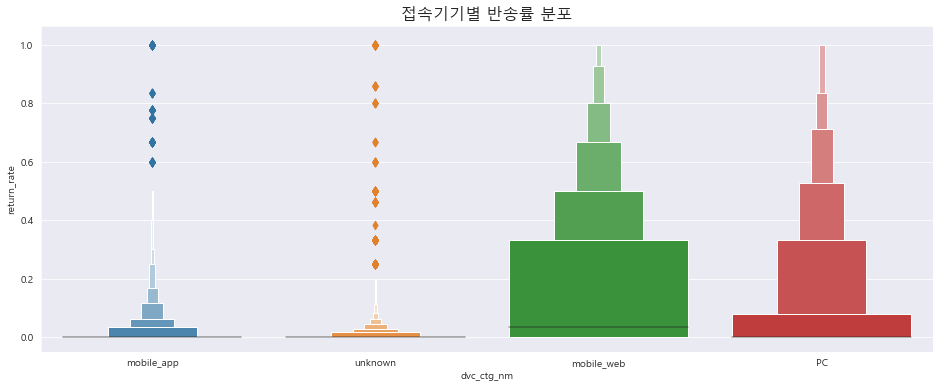

In [13]:
plt.figure(figsize=(16,6))
sns.boxenplot(x=online_df.dvc_ctg_nm, y=online_df.return_rate)
plt.title("접속기기별 반송률 분포", fontsize = 16)

In [1]:
"""plt.figure(figsize=(16,6))
sns.boxenplot(x=online_df.trfc_src, y=online_df.return_rate)
plt.title("접속경로별 반송률 분포", fontsize = 16)"""

'plt.figure(figsize=(16,6))\nsns.boxenplot(x=online_df.trfc_src, y=online_df.return_rate)\nplt.title("접속경로별 반송률 분포", fontsize = 16)'

In [2]:
"""plt.figure(figsize=(16,6))
sns.boxplot(x=online_df.dvc_ctg_nm, y=online_df.return_rate)"""

'plt.figure(figsize=(16,6))\nsns.boxplot(x=online_df.dvc_ctg_nm, y=online_df.return_rate)'

In [29]:
main_access_time = pd.read_csv("main_access_time.csv")

#### 주접속시간대별 구매목록 차이?

In [31]:
online_df = online_df.merge(main_access_time)

In [43]:
tmp = online_df[online_df.action_type == 6].groupby(["pattern", "clac_nm1"]).size().reset_index().sort_values(by = ["pattern",0], ascending = [1,0])

In [82]:
with open('buying_sess_list.pickle', 'rb') as f:
    buying_sess_list = pickle.load(f)

In [88]:
is_buying_session = pd.concat([online_df.drop_duplicates(["clnt_id","sess_id"], keep = "first")[["clnt_id","sess_id"]].reset_index(drop = True),
          pd.DataFrame(buying_sess_list)], axis=1)

In [90]:
is_buying_session.rename(columns={0 : "is_buying_session"}, inplace=True)

In [91]:
online_df = online_df.merge(is_buying_session, how = "left", on = ["clnt_id","sess_id"])

In [95]:
tmp = online_df[online_df.is_buying_session == 1].drop_duplicates(["clnt_id","is_buying_session"], keep = "first")

In [101]:
first_buying_session = tmp[["clnt_id","sess_id"]]

In [ ]:
online_df[(online_df.clnt_id.isin(first_buying_session.clnt_id))]

In [105]:
clac_nm1_list = online_df.clac_nm1.unique().tolist()

In [111]:
tot_lst = []
for i, (clnt_id, sess_id) in enumerate(first_buying_session.values):
    if i % 1000 == 0 :
        print(i)
    tmp_lst = np.zeros(len(clac_nm1_list))
    df = online_df[(online_df.clnt_id == clnt_id) & (online_df.sess_id==sess_id)]
    clac1_lst = df.clac_nm1.unique().tolist()
    for clac1 in clac1_lst:
        tmp_lst[clac_nm1_list.index(clac1)] = 1
    tot_lst.append(tmp_lst)
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [115]:
first_buying_cat = pd.DataFrame(tot_lst)

In [119]:
first_buying_cat.columns = clac_nm1_list

In [125]:
first_buying_cat.drop(first_buying_cat.columns[0], axis=1, inplace=True)

In [127]:
first_buying_cat.index = first_buying_session.clnt_id

In [130]:
first_buying_cat.reset_index(inplace = True)

In [143]:
tmp = online_df[["clnt_id","pattern"]].drop_duplicates("clnt_id", keep = "first").merge(first_buying_cat).groupby("pattern").sum().drop("clnt_id", axis=1).T

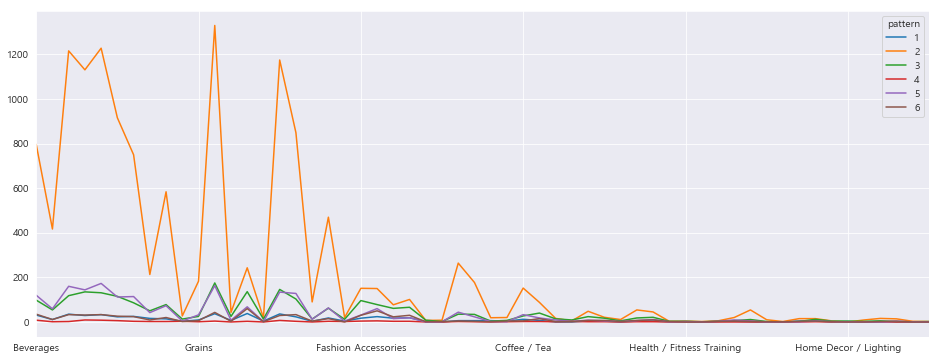

In [149]:
tmp.plot(figsize = (16,6))

In [80]:
for i in range(1,7):
    globals()["tmp_{}".format(i)] = tmp[tmp.pattern == i].iloc[:10]

In [81]:
multi_table([tmp_1,tmp_2,tmp_3,tmp_4,tmp_5,tmp_6])

,pattern,clac_nm1,0
46,1,Vegetables,180
40,1,Substitute Foods,115
6,1,Chilled Foods,105
47,1,Women's Clothing,104
16,1,Frozen Foods,102
12,1,Dairy Products,100
28,1,Meats,99
36,1,Snack Foods,94
17,1,Fruits,89
2,1,Beverages,85


In [68]:
texts = []
for i in range(1,7):
    df = online_df[(online_df.action_type == 6) & (online_df.pattern == i)]
    text = df.clac_nm1.dropna().values
    texts.append(text)

In [90]:
texts =online_df.sech_kwd.dropna().tolist()

In [96]:
txt = ""
for text in texts:
    txt = txt + "" + text

In [8]:
mask = np.array(Image.open("plots/wordcloud_mask.png"))

In [71]:
# texts = online_df.sech_kwd.dropna().astype(str).value_counts().to_dict()

In [4]:
texts = online_df.sech_kwd.dropna().astype(str).tolist()

In [5]:
pd.options.display.max_rows = 200

In [6]:
import random

In [7]:
random.shuffle(texts)

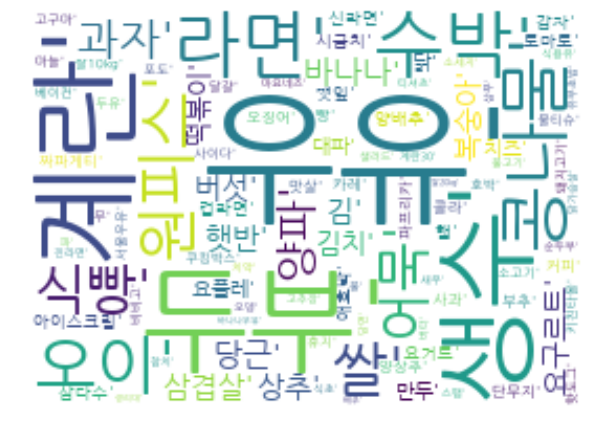

In [9]:
wordcloud = WordCloud(
    font_path = "C://Windows/Fonts/NanumGothic.ttf",
    width = 2000,
    height = 800,
    mask = mask,
    background_color = 'white',
    max_words = 100,
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize = (8, 6),
    facecolor = 'white',
    edgecolor = 'white'
)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [16]:
mask = np.array(Image.open("plots/wordcloud_mask.png"))

In [15]:
wordcloud = WordCloud(
    font_path = "C://Windows/Fonts/NanumGothic.ttf",
    width = 800,
    height = 800,
    background_color="white",
    mask = mask,
    max_words = 100,
    stopwords = STOPWORDS
)

wordcloud = wordcloud.generate_from_frequencies(str(texts))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

AttributeError: 'str' object has no attribute 'items'

In [150]:
wordcloud.words_

{"감자'": 0.13125413268679745,
 "계란'": 0.5592902799206524,
 "과자'": 0.20652413489089708,
 "김'": 0.17247079567996473,
 "김치'": 0.15307471897729777,
 "깻잎'": 0.12794798324884285,
 "닭'": 0.14513996032620674,
 "당근'": 0.19638527661450297,
 "대파'": 0.14436852545735068,
 "두부'": 0.5767026669605466,
 "떡볶이'": 0.15307471897729777,
 "라면'": 0.2886268459334362,
 "만두'": 0.14580119021379767,
 "맛살'": 0.11130703107780472,
 "바나나'": 0.20376901035926823,
 "버섯'": 0.16751157152303284,
 "복숭아'": 0.17522592021159356,
 "빵'": 0.12188670927925942,
 "사과'": 0.12155609433546397,
 "삼겹살'": 0.18216883403129822,
 "삼다수'": 0.1303724928366762,
 "상추'": 0.18260965395635884,
 "생수'": 0.47597531408419663,
 "수박'": 0.2972228344721181,
 "시금치'": 0.13544192197487326,
 "식빵'": 0.22184262728675336,
 "신라면'": 0.12728675336125192,
 "쌀'": 0.22867533612519286,
 "아이스크림'": 0.13918889133788848,
 "애호박'": 0.13169495261185807,
 "양배추'": 0.13103372272426714,
 "양상추'": 0.1108662111527441,
 "양파'": 0.20630372492836677,
 "어묵'": 0.20916905444126074,
 "오이'": 0.2

#### 소분류

In [7]:
tmp_df = online_df[online_df.action_type == 6][["clnt_id","clac_nm3"]].fillna("unknown")

In [12]:
item_list = tmp_df.groupby(["clnt_id"]).agg({"clac_nm3" : "unique"}).reset_index()

In [20]:
buying_list_clac_3 = pd.concat([tmp_df[["clnt_id"]], pd.get_dummies(tmp_df.clac_nm3)],axis=1).groupby("clnt_id").sum().reset_index()

In [21]:
buying_list_clac_3.to_csv("buying_list_clac3.csv", index = False)

####  LSTM

In [7]:
pre_df = online_df[online_df.action_type == 6].groupby(["clac_nm1","month","day"]).size().reset_index()

In [8]:
#online_df.drop_duplicates(["month","day"], keep = "first").head()

In [9]:
day_range = pd.DataFrame(pd.date_range(start='20190701', end='20190930')).rename(columns = {0 : "time"})

In [10]:
pre_df2 = pd.concat([pd.DataFrame(online_df.clac_nm1.dropna().unique())]*92).sort_values(by = 0).reset_index(drop = True)

In [11]:
time = pd.concat([day_range] * 56).reset_index(drop = True)

In [12]:
pre_df2 = pd.concat([pre_df2, time], axis=1)

In [13]:
pre_df2.rename(columns={ 0 : "clac_nm1"}, inplace=True)

In [14]:
pre_df2['month'] = pre_df2.time.dt.month
pre_df2['day'] = pre_df2.time.dt.day

In [15]:
df = pre_df2.merge(pre_df, how = "left").fillna(0)

In [16]:
df.rename(columns= {0 : "sales"}, inplace = True)

In [17]:
df.shape

(5152, 5)

In [36]:
# train_set = df.set_index("time").drop(["month","day"], axis=1)[["sales"]].values.reshape(56,92)

In [1]:
"""
with open('sales_by_day.pickle', 'wb') as f:
    pickle.dump(train_set, f, protocol=pickle.HIGHEST_PROTOCOL)
"""

"\nwith open('sales_by_day.pickle', 'wb') as f:\n    pickle.dump(train_set, f, protocol=pickle.HIGHEST_PROTOCOL)\n"

In [18]:
with open('sales_by_day.pickle', 'rb') as f:
    sales_by_day = pickle.load(f)

In [20]:
clac_nm_list = sorted(online_df.clac_nm1.dropna().unique().tolist())

In [46]:
"""
with open("clac_nm_list.pickle", "wb") as f:
    pickle.dump(clac_nm_list, f, protocol=pickle.HIGHEST_PROTOCOL)
"""

In [21]:
def data_generate(array, train_len = 7,pred_len = 1, num_features = 1):
    data = []
    label = []
    num_object = len(array) - (train_len + pred_len)
    for i in range(0,num_object):
        data.append(array[i:i+train_len])
        if num_features > 1:
            label.append(array.reshape(len(array)*num_features)[3*i:3*i+num_features*pred_len:num_features])
        else:
            label.append(array[i+train_len:i+train_len+pred_len])
    data = np.array(data).reshape(num_object,train_len,num_features)
    label = np.array(label).reshape(num_object,pred_len,1)
    return data, label, num_object

In [22]:
def get_model(train_len=7, pred_len=1,num_features=1):
    model = Sequential()
    model.add(LSTM(200, input_shape = (train_len, num_features)))
    model.add(Dense(pred_len))
    model.compile(loss = "mse", optimizer='adam')
    return model

In [28]:
def draw_plot(data, label, filename, title, num_object, save = False):
    fig, ax = plt.subplots(figsize = (8,5))
    sns.lineplot(x = range(1,num_object+1), y=label.reshape(num_object,), ax = ax, color = "k", label = "actual", marker='s')
    sns.lineplot(x = range(1,num_object+1), y=np.round(model.predict(data)).reshape(num_object,), ax = ax, label = "pred", marker='o')
    ax.set_title(title)
    plt.show()
    if save:
        fig.savefig(filename)

In [ ]:
holiday_df = pd.DataFrame(holiday_list).rename(columns = {0 : "time"})
holiday_df['time'] = pd.to_datetime(holiday_df.time)
holiday_df["is_holiday"] = 1

In [36]:
tmp_data = pd.DataFrame(sales_by_day[53])
tmp_data = pd.concat([tmp_data, time.drop_duplicates()], axis=1)
tmp_data["weekday"] = tmp_data.time.dt.weekday

tmp_data = tmp_data.merge(holiday_df, how = "left", on = "time").fillna(0)
tmp_data["holiday_tomorrow"] = tmp_data.is_holiday.shift(-1, fill_value=0)

tmp_data["weekend"] = np.where(tmp_data.weekday.isin([0,1,2,3,4]), 0, 1)
tmp_data["weekend_tomorrow"] = tmp_data.weekend.shift(-1, fill_value=0)
tmp_data.drop(["weekday","is_holiday","weekend", "time"], axis=1, inplace=True)

In [3]:
"""epochs = 200
batch_size = 8

for i, sales in enumerate(sales_by_day):
    if not os.path.exists("./plots/"):
        os.mkdir("./plots/")
    if not os.path.exists("./models/"):
        os.mkdir("./models/")
    filename = "./plots/lstm_lineplot_{}.png".format(i)
    modelname = "./models/lstm_model_{}.h5".format(clac_nm_list[i].replace("/", "_"))
    title = clac_nm_list[i]
    
    tmp_data = pd.concat([pd.DataFrame(sales), time.drop_duplicates()], axis=1)
    tmp_data["weekday"] = tmp_data.time.dt.weekday
    
    tmp_data = tmp_data.merge(holiday_df, how = "left", on = "time").fillna(0)
    tmp_data["holiday_tomorrow"] = tmp_data.is_holiday.shift(-1, fill_value=0)
    tmp_data["weekend"] = np.where(tmp_data.weekday.isin([0,1,2,3,4]), 0, 1)
    tmp_data["weekend_tomorrow"] = tmp_data.weekend.shift(-1, fill_value=0)
    tmp_data.drop(["weekday","is_holiday","weekend", "time"], axis=1, inplace=True)
    
    data, label, num_object = data_generate(tmp_data.values, num_features=3, pred_len=1)
    model = get_model(num_features=3, pred_len=1)
    model.fit(data, label, epochs=epochs, batch_size=batch_size, verbose=0)
    save_model(model, filepath=modelname)
    draw_plot(data = data, label = label, filename=filename, title = title, num_object = num_object)"""

'epochs = 200\nbatch_size = 8\n\nfor i, sales in enumerate(sales_by_day):\n    if not os.path.exists("./plots/"):\n        os.mkdir("./plots/")\n    if not os.path.exists("./models/"):\n        os.mkdir("./models/")\n    filename = "./plots/lstm_lineplot_{}.png".format(i)\n    modelname = "./models/lstm_model_{}.h5".format(clac_nm_list[i].replace("/", "_"))\n    title = clac_nm_list[i]\n    \n    tmp_data = pd.concat([pd.DataFrame(sales), time.drop_duplicates()], axis=1)\n    tmp_data["weekday"] = tmp_data.time.dt.weekday\n    \n    tmp_data = tmp_data.merge(holiday_df, how = "left", on = "time").fillna(0)\n    tmp_data["holiday_tomorrow"] = tmp_data.is_holiday.shift(-1, fill_value=0)\n    tmp_data["weekend"] = np.where(tmp_data.weekday.isin([0,1,2,3,4]), 0, 1)\n    tmp_data["weekend_tomorrow"] = tmp_data.weekend.shift(-1, fill_value=0)\n    tmp_data.drop(["weekday","is_holiday","weekend", "time"], axis=1, inplace=True)\n    \n    data, label, num_object = data_generate(tmp_data.values

In [444]:
data, label, num_object = data_generate(tmp_data.values, num_features=3, pred_len=1)

In [445]:
model = get_model(num_features=3, pred_len = 1)
# data, label = data_generate(sales_by_day[34])

In [446]:
epochs = 100
batch_size = 8

In [449]:
model.fit(data, label, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 84 samples
Epoch 1/100
84/84 [==============================] - 0s 1ms/sample - loss: 820.8278
Epoch 2/100
84/84 [==============================] - 0s 1ms/sample - loss: 785.3749
Epoch 3/100
84/84 [==============================] - 0s 1ms/sample - loss: 751.6893
Epoch 4/100
84/84 [==============================] - 0s 1ms/sample - loss: 729.0345
Epoch 5/100
84/84 [==============================] - 0s 1ms/sample - loss: 698.2069
Epoch 6/100
84/84 [==============================] - 0s 1ms/sample - loss: 685.6572
Epoch 7/100
84/84 [==============================] - 0s 1ms/sample - loss: 658.8783
Epoch 8/100
84/84 [==============================] - 0s 1ms/sample - loss: 630.9970
Epoch 9/100
84/84 [==============================] - 0s 1ms/sample - loss: 603.9320
Epoch 10/100
84/84 [==============================] - 0s 1ms/sample - loss: 587.0098
Epoch 11/100
84/84 [==============================] - 0s 1ms/sample - loss: 565.7918
Epoch 12/100
84/84 [==============================] - 

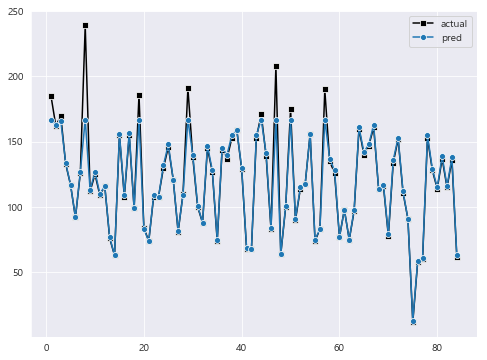

In [450]:
fig, ax = plt.subplots(figsize = (8,6))
sns.lineplot(x = range(1,85), y=label.reshape(84,), ax = ax, color = "k", label = "actual", marker='s')
sns.lineplot(x = range(1,85), y=np.round(model.predict(data)).reshape(84,), ax = ax, label = "pred", marker='o')

In [364]:
sales_by_day[34]

array([107., 106., 149.,  82.,  93.,  68.,  54., 195.,  85., 112., 105.,
        81.,  76.,  56.,  90.,  88., 110.,  82., 148.,  88.,  75., 100.,
        79.,  97., 102.,  80.,  56.,  47., 136.,  89., 108.,  88., 127.,
        97.,  41., 122.,  98., 127., 156., 104.,  59.,  45., 106., 120.,
       127.,  78., 138.,  54.,  48., 139.,  57.,  85.,  65., 117.,  41.,
        34., 154.,  84., 102.,  57.,  82.,  39.,  70., 114.,  71., 107.,
       136., 101.,  62.,  40.,  85.,  95.,  75.,  53.,   6.,  34.,  28.,
       103.,  62.,  96., 106.,  83.,  83.,  42., 147.,  87.,  97.,  67.,
       111.,  49.,  60.,  98.])

In [454]:
timedelta = pd.read_csv("data_about_timedelta.csv").drop_duplicates("clnt_id")

In [455]:
timedelta

,clnt_id,sess_id,time_to_last,time_pss_from_previous_sess,mean_pss_time
0,1,1,20,0,10.000000
2,2,1,65,0,1.526316
22,3,1,78,0,0.000000
23,4,1,36,0,0.000000
24,5,1,43,0,0.000000
25,6,1,83,0,21.000000
27,7,1,88,0,11.000000
32,8,1,21,0,6.000000
34,9,1,92,0,2.375000
67,10,1,88,0,0.000000
